# Gözetimsiz Öğrenme ile Müşteri Segmentasyonu
# MODEL2

In [181]:
#define the library

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from scipy import stats

from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score


In [182]:
# make some settings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

In [183]:
# reading the dataset
# flo is the original dataset

flo = pd.read_csv("C:/Users/avcil/projects/project/flo_data.csv")  


# flo = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")
# df = flo.copy()

In [184]:
flo.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [185]:
# create a copy of flo dataset

df = flo.copy()

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [187]:
# Converting data containing date information to datetime type

date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [188]:
#check chancing

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [189]:
df["last_order_date"].max() 
# output 2021-05-30 

Timestamp('2021-05-30 00:00:00')

In [190]:
# determined the last_date

last_date = dt.datetime(2021,6,1)

In [191]:
# create a new variable called recency

df["recency"] = (last_date - df["last_order_date"]).astype('timedelta64[D]')

# recency: It keeps information on how many days ago the person last shopped.
# Recency shows when our customer last shopped from our brand.

In [192]:
# create a new variable called tenure

df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')

# tenure : It keeps the difference between the first purchase and the last purchase.

In [193]:
# create a new variable total order num (online + offline)

df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

In [194]:
# create a new variable total customer value (online + offline)

df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [195]:
# create a new variable called ratio 

df["ratio"] = df["customer_value_total"] / df["order_num_total"] 

In [196]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure,order_num_total,customer_value_total,ratio
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],95.00,119.00,5.00,939.37,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105.00,1469.00,21.00,2013.55,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",186.00,366.00,5.00,585.32,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",135.00,11.00,2.00,121.97,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],86.00,582.00,2.00,209.98,104.99


In [197]:
df.groupby("order_channel").agg({"master_id": "count",
                                 "order_num_total": "sum",
                                 "customer_value_total": "sum"})

,master_id,order_num_total,customer_value_total
order_channel,,,
Android App,9495,52269.00,7819062.76
Desktop,2735,10920.00,1610321.46
Ios App,2833,15351.00,2525999.93
Mobile,4882,21679.00,3028183.16


In [198]:
# List the top 10 customers who place the most orders

df.sort_values("order_num_total", ascending=False)[:10]

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure,order_num_total,customer_value_total,ratio
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.00,2.00,684.97,45220.13,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",32.00,2758.00,202.00,45905.10,227.25
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.00,1.00,49.99,12232.25,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",23.00,2999.00,131.00,12282.24,93.76
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,Android App,Offline,2019-08-07,2020-11-04,2020-09-07,2020-11-04,2.00,109.00,10239.46,143.98,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",209.00,455.00,111.00,10383.44,93.54
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,Android App,Offline,2018-10-18,2020-06-30,2018-10-18,2020-06-30,1.00,87.00,8432.25,139.98,[ERKEK],336.00,621.00,88.00,8572.23,97.41
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-02-14,2021-04-05,2021-04-05,2020-02-17,2.00,81.00,3997.55,242.81,[ERKEK],57.00,781.00,83.00,4240.36,51.09
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.00,1.00,1263.76,32654.34,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",14.00,2681.00,82.00,33918.10,413.64
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2019-02-11,2021-02-11,2021-02-11,2020-12-24,3.00,74.00,4640.77,543.28,"[KADIN, AKTIFSPOR]",110.00,731.00,77.00,5184.05,67.33
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2015-09-12,2021-04-01,2021-04-01,2019-10-08,72.00,3.00,292.93,5004.95,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",61.00,2028.00,75.00,5297.88,70.64
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.00,1.00,82.48,16836.09,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",49.00,1434.00,70.00,16918.57,241.69
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.00,4.00,843.68,17599.89,"[ERKEK, KADIN, AKTIFSPOR]",32.00,439.00,70.00,18443.57,263.48


In [238]:
# List the top 100 customers who place the most orders

df.sort_values("order_num_total", ascending=False)[:50]

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure,order_num_total,customer_value_total,ratio
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.00,2.00,684.97,45220.13,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",32.00,2758.00,202.00,45905.10,227.25
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.00,1.00,49.99,12232.25,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",23.00,2999.00,131.00,12282.24,93.76
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,Android App,Offline,2019-08-07,2020-11-04,2020-09-07,2020-11-04,2.00,109.00,10239.46,143.98,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",209.00,455.00,111.00,10383.44,93.54
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,Android App,Offline,2018-10-18,2020-06-30,2018-10-18,2020-06-30,1.00,87.00,8432.25,139.98,[ERKEK],336.00,621.00,88.00,8572.23,97.41
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-02-14,2021-04-05,2021-04-05,2020-02-17,2.00,81.00,3997.55,242.81,[ERKEK],57.00,781.00,83.00,4240.36,51.09
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.00,1.00,1263.76,32654.34,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",14.00,2681.00,82.00,33918.10,413.64
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2019-02-11,2021-02-11,2021-02-11,2020-12-24,3.00,74.00,4640.77,543.28,"[KADIN, AKTIFSPOR]",110.00,731.00,77.00,5184.05,67.33
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2015-09-12,2021-04-01,2021-04-01,2019-10-08,72.00,3.00,292.93,5004.95,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",61.00,2028.00,75.00,5297.88,70.64
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.00,1.00,82.48,16836.09,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",49.00,1434.00,70.00,16918.57,241.69
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.00,4.00,843.68,17599.89,"[ERKEK, KADIN, AKTIFSPOR]",32.00,439.00,70.00,18443.57,263.48


In [200]:
# List the top 10 customers with the highest ratio 

df.sort_values("ratio", ascending=False)[:10]

# A high ratio represents the money spent per shopping.    
#  Rationun yuksek olmasi alisveris basina harcanan parayi temsil ediyor
# Yuksek fiyatli alisverisler yapildigini gosteriyor

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure,order_num_total,customer_value_total,ratio
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,Android App,Offline,2021-04-07,2021-04-27,2021-04-07,2021-04-27,1.00,3.00,18119.14,2587.20,[AKTIFSPOR],35.00,20.00,4.00,20706.34,5176.59
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,Ios App,Offline,2021-03-01,2021-04-13,2021-03-18,2021-04-13,10.00,1.00,538.94,30688.47,"[ERKEK, KADIN, AKTIFSPOR]",49.00,43.00,11.00,31227.41,2838.86
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,Desktop,Desktop,2019-06-25,2020-06-21,2020-06-21,2019-06-25,6.00,1.00,79.99,7665.28,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",345.00,362.00,7.00,7745.27,1106.47
15516,9083981a-f59e-11e9-841e-000d3a38a36f,Ios App,Ios App,2019-10-23,2021-01-10,2021-01-10,2019-10-23,3.00,1.00,89.99,4271.45,"[ERKEK, AKTIFSPOR]",142.00,445.00,4.00,4361.44,1090.36
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,Android App,Android App,2021-03-27,2021-05-24,2021-05-24,2021-03-27,1.00,1.00,1074.89,650.49,"[ERKEK, COCUK, KADIN]",8.00,58.00,2.00,1725.38,862.69
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,Desktop,Desktop,2019-08-07,2020-09-09,2020-09-09,2019-08-07,1.00,1.00,199.99,1519.17,[KADIN],265.00,399.00,2.00,1719.16,859.58
7936,ae4ce104-dbd4-11ea-8757-000d3a38a36f,Ios App,Ios App,2020-08-11,2020-09-06,2020-09-06,2020-08-11,2.00,1.00,80.74,2452.30,[KADIN],268.00,26.00,3.00,2533.04,844.35
9738,3a27b334-dff4-11ea-acaa-000d3a38a36f,Android App,Offline,2020-08-17,2021-05-24,2020-08-17,2021-05-24,1.00,2.00,301.34,2209.83,"[ERKEK, KADIN]",8.00,280.00,3.00,2511.17,837.06
1853,f02473b0-43c3-11eb-806e-000d3a38a36f,Mobile,Offline,2020-12-21,2021-04-21,2020-12-21,2021-04-21,1.00,1.00,1406.85,264.90,"[COCUK, AKTIFSPOR]",41.00,121.00,2.00,1671.75,835.88
2291,26ac1432-1dd3-11ea-8bf2-000d3a38a36f,Ios App,Ios App,2019-07-18,2020-08-11,2020-08-11,2019-07-18,2.00,1.00,19.99,2321.68,"[ERKEK, COCUK, KADIN]",294.00,390.00,3.00,2341.67,780.56


In [201]:
# selected some variables and assigned them to model_df

model_df = df[["order_num_total", 
               "customer_value_total",
               "recency",
               "ratio"]]

model_df.head()

,order_num_total,customer_value_total,recency,ratio
0,5.00,939.37,95.00,187.87
1,21.00,2013.55,105.00,95.88
2,5.00,585.32,186.00,117.06
3,2.00,121.97,135.00,60.98
4,2.00,209.98,86.00,104.99


In [202]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_num_total       19945 non-null  float64
 1   customer_value_total  19945 non-null  float64
 2   recency               19945 non-null  float64
 3   ratio                 19945 non-null  float64
dtypes: float64(4)
memory usage: 623.4 KB


In [203]:
model_df.isnull().sum()

order_num_total         0
customer_value_total    0
recency                 0
ratio                   0
dtype: int64

In [204]:
model_df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total,19945.00,5.02,4.74,2.00,3.00,4.00,6.00,202.00
customer_value_total,19945.00,751.24,895.40,44.98,339.98,545.27,897.78,45905.10
recency,19945.00,134.46,103.28,2.00,43.00,111.00,202.00,367.00
ratio,19945.00,152.40,83.50,22.49,103.49,136.73,182.44,5176.59


In [205]:
# check the skewness

def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

order_num_total's: Skew: 9.142209056779548, : SkewtestResult(statistic=146.5525046688009, pvalue=0.0)
customer_value_total's: Skew: 17.40528126665466, : SkewtestResult(statistic=176.82377384378034, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
ratio's: Skew: 14.026592674273598, : SkewtestResult(statistic=166.66841266578655, pvalue=0.0)


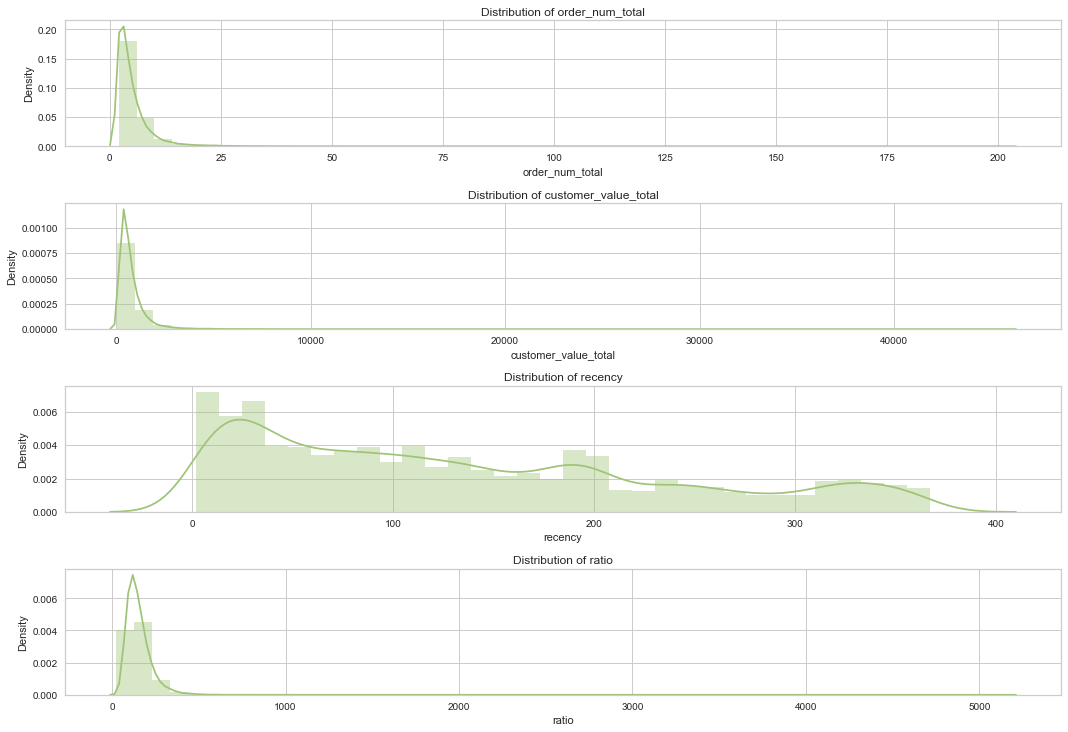

In [206]:
# draw all variables to check&see skewness
plt.figure(figsize=(15, 15))

plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total')

plt.subplot(6, 1, 2)
check_skew(model_df,'customer_value_total')

plt.subplot(6, 1, 3)
check_skew(model_df,'recency')

plt.subplot(6, 1, 4)
check_skew(model_df,'ratio')

plt.tight_layout()
# plt.savefig('before_transform.png', format='png', dpi=1000)   #if you want to save the output image
plt.show()

In [207]:
model_df.columns

Index(['order_num_total', 'customer_value_total', 'recency', 'ratio'], dtype='object')

In [208]:
# applying Log transformation to ensure normal distribution

model_df['order_num_total'] = np.log1p(model_df['order_num_total'])
model_df['customer_value_total'] = np.log1p(model_df['customer_value_total'])
model_df['recency'] = np.log1p(model_df['recency'])
model_df['ratio'] = np.log1p(model_df['ratio'])


C:\Users\avcil\AppData\Local\Temp\ipykernel_16724\3428881644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total'] = np.log1p(model_df['order_num_total'])
C:\Users\avcil\AppData\Local\Temp\ipykernel_16724\3428881644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['customer_value_total'] = np.log1p(model_df['customer_value_total'])
C:\Users\avcil\AppData\Local\Temp\ipykernel_16724\3428881644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [209]:
model_df.head()

,order_num_total,customer_value_total,recency,ratio
0,1.79,6.85,4.56,5.24
1,3.09,7.61,4.66,4.57
2,1.79,6.37,5.23,4.77
3,1.10,4.81,4.91,4.13
4,1.10,5.35,4.47,4.66


In [210]:
# Scaling     

sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total,customer_value_total,recency,ratio
0,0.16,0.44,0.72,0.39
1,0.47,0.55,0.74,0.26
2,0.16,0.37,0.86,0.30
3,0.00,0.14,0.79,0.18
4,0.00,0.22,0.70,0.28


# KMEANS MODEL

In [211]:
# I am copying my dataset to use it in the Kmeans model, so that the original version is not corrupted.

k_means_model_df = model_df.copy()

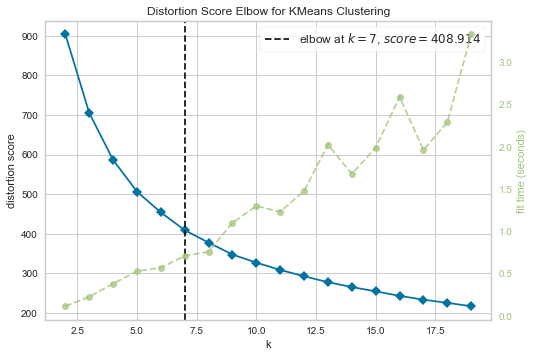

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [212]:
# Determine the optimal number of segments
# Let's see the distribution and decide the optimal number of segments with KElbowVisualizer
  
kmeans = KMeans()
elbows = KElbowVisualizer(kmeans, k=(2, 20))

elbows.fit(k_means_model_df)
elbows.show()

In [213]:
# Create model 

k_means = KMeans(n_clusters = 7, random_state= 42)
k_means.fit(k_means_model_df)

segments = k_means.labels_
segments

# created a total of 7 segments/groups

array([2, 3, 1, ..., 5, 3, 6])

In [214]:
# appending labels to data points

k_means_model_df["segment"] = segments + 1
k_means_model_df.head(10)

,order_num_total,customer_value_total,recency,ratio,segment
0,0.16,0.44,0.72,0.39,3
1,0.47,0.55,0.74,0.26,4
2,0.16,0.37,0.86,0.30,2
3,0.00,0.14,0.79,0.18,7
4,0.00,0.22,0.70,0.28,3
5,0.07,0.21,0.69,0.20,3
6,0.12,0.30,0.90,0.26,7
7,0.00,0.18,0.95,0.23,7
8,0.16,0.45,0.70,0.41,3
9,0.00,0.19,0.91,0.24,7


In [215]:
# Size of the segments

size = k_means_model_df.groupby('segment').size().to_frame()
size.columns = ["KM_size"]
size

,KM_size
segment,
1,2424
2,4208
3,3991
4,2532
5,1892
6,1637
7,3261


# VISUALIZATION 

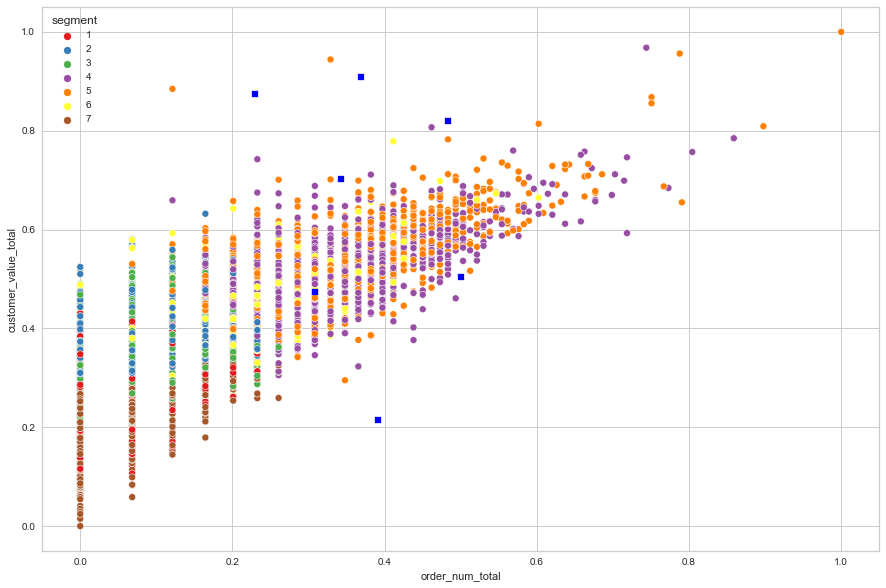

In [216]:
# Visualization of total number of orders and total value

fig1, ax = plt.subplots(figsize=(15, 10))

scat_1 = sns.scatterplot(x='order_num_total' , y= 'customer_value_total', 
                         data= k_means_model_df, hue='segment', 
                         ax=ax, palette='Set1', legend='full')

ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='s', s=40, c="blue")
plt.show()

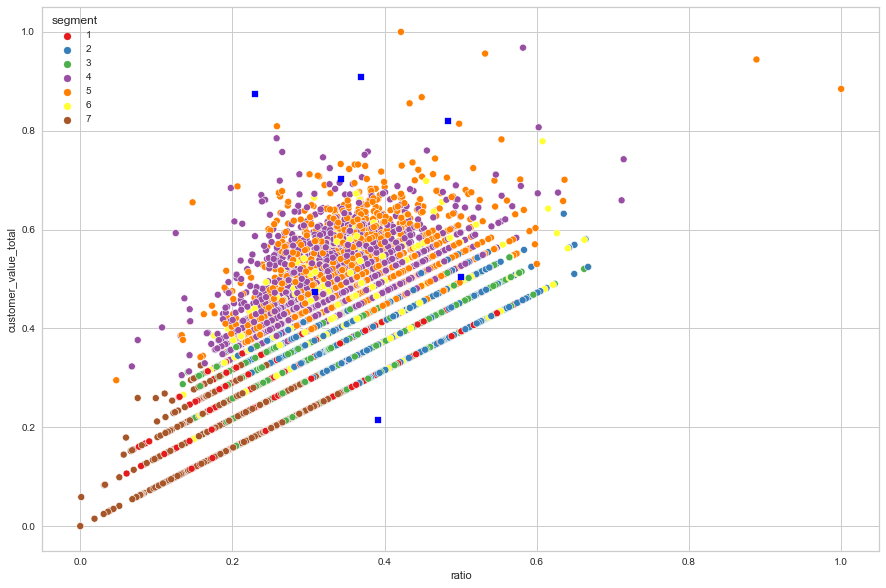

In [217]:
# Visualization of ratio and total value

fig1, ax = plt.subplots(figsize=(15, 10))

scat_1 = sns.scatterplot(x='ratio' , y= 'customer_value_total', 
                         data= k_means_model_df, hue='segment', 
                         ax=ax, palette='Set1', legend='full')

ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='s', s=40, c="blue")
plt.show()

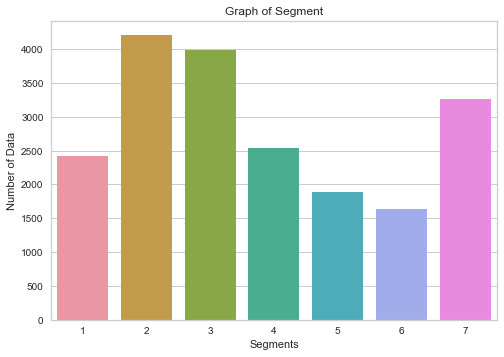

In [218]:
# Cluster membership chart

sns.countplot(x='segment', data=k_means_model_df)
plt.title('Graph of Segment')
plt.xlabel('Segments')
plt.ylabel('Number of Data')
plt.show()

In [219]:
k_means_model_df.columns

Index(['order_num_total', 'customer_value_total', 'recency', 'ratio', 'segment'], dtype='object')

In [220]:
# Segments combined with original data

final =  df[["master_id","order_num_total_ever_online","order_num_total_ever_offline",
               "customer_value_total_ever_offline",
               "customer_value_total_ever_online",
               "recency",
               "tenure",
               "order_num_total",
               "customer_value_total",
               "ratio"]]

final["KM_segment"] = k_means_model_df["segment"]  

final.head()


C:\Users\avcil\AppData\Local\Temp\ipykernel_16724\3918667130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["KM_segment"] = k_means_model_df["segment"]


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,order_num_total,customer_value_total,ratio,KM_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,5.00,939.37,187.87,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,21.00,2013.55,95.88,4
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,5.00,585.32,117.06,2
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,2.00,121.97,60.98,7
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,2.00,209.98,104.99,3


In [221]:
# Let's examine each segment statistically

final.groupby("KM_segment").agg({ "order_num_total_ever_online":["min","mean","max"],
                                  "order_num_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_online":["min","mean","max"],
                                  "recency":["min","mean","max"],
                                  "tenure":["min","mean","max"],
                                  "order_num_total":["min","mean","max"],
                                  "customer_value_total": ["min","mean","max"],
                                  "ratio" :["min","mean","max", "count"] })

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                  recency               tenure                order_num_total              customer_value_total                  ratio                     
                                   min mean    max                          min mean    max                               min   mean      max                              min    mean      max     min   mean    max    min   mean     max             min  mean    max                  min    mean      max   min   mean     max count
KM_segment                                                                                                                                                                                                                                                                                                                               
1                                 1.00 1.69   6.00                         1.00 1.47   6.00                             12.99 178.56   789.94                            19.99  253.85  1135.26    8.00  30.19  61.00   0.00 566.83 2928.00            2.00  3.16   7.00                44.98  432.41  1341.33 22.49 142.93  596.10  2424
2                                 1.00 1.97   6.00                         1.00 1.69   6.00                             10.00 260.60  1719.96                            12.99  366.11  3535.68  114.00 246.87 367.00   0.00 544.76 2803.00            2.00  3.66   8.00               295.47  626.71  3615.67 63.27 182.94  859.58  4208
3                                 1.00 1.86   6.00                         1.00 1.75   7.00                             11.98 240.68  1416.85                            14.00  295.38  1499.97   41.00  90.21 153.00   0.00 619.18 2964.00            2.00  3.60   8.00               139.98  536.06  1965.90 42.74 156.98  835.88  3991
4                                 1.00 7.17  67.00                         1.00 3.00 109.00                             10.49 387.94 10239.46                            19.99 1083.03 36687.80   68.00 168.81 367.00   7.00 993.51 2959.00            4.00 10.17 111.00               377.80 1470.97 36818.29 32.87 151.51 1106.47  2532
5                                 1.00 7.69 200.00                         1.00 2.82  81.00                             12.99 409.28 18119.14                            39.99 1339.22 45220.13    5.00  36.52  79.00   3.00 913.51 3034.00            3.00 10.51 202.00               351.88 1748.50 45905.10 29.32 177.16 5176.59  1892
6                                 1.00 3.16  36.00                         1.00 2.00  14.00                             12.99 281.20  2245.33                            29.74  543.80  9723.33    2.00   8.28  18.00   0.00 721.84 3031.00            2.00  5.15  37.00                65.91  825.01  9953.31 32.95 168.50  862.69  1637
7                                 1.00 1.34   7.00                         1.00 1.33   6.00                             10.49 109.65   392.94                            14.00  128.19   410.93   57.00 214.54 367.00   0.00 532.70 2828.00            2.00  2.67   8.00                44.98  237.83   464.93 22.49  92.67  169.37  3261

In [222]:
# Let's examine each segment statistically

final.groupby("KM_segment").agg({ 
                                  "recency":["min","mean","max"],
                                  "order_num_total":["min","mean","max"],
                                  "customer_value_total": ["min","mean","max"],
                                  "ratio" :["min","mean","max", "count"] })

recency               order_num_total              customer_value_total                  ratio                     
               min   mean    max             min  mean    max                  min    mean      max   min   mean     max count
KM_segment                                                                                                                    
1             8.00  30.19  61.00            2.00  3.16   7.00                44.98  432.41  1341.33 22.49 142.93  596.10  2424
2           114.00 246.87 367.00            2.00  3.66   8.00               295.47  626.71  3615.67 63.27 182.94  859.58  4208
3            41.00  90.21 153.00            2.00  3.60   8.00               139.98  536.06  1965.90 42.74 156.98  835.88  3991
4            68.00 168.81 367.00            4.00 10.17 111.00               377.80 1470.97 36818.29 32.87 151.51 1106.47  2532
5             5.00  36.52  79.00            3.00 10.51 202.00               351.88 1748.50 45905.10 29.32 177.16 5176.59  1892
6             2.00   8.28  18.00            2.00  5.15  37.00                65.91  825.01  9953.31 32.95 168.50  862.69  1637
7            57.00 214.54 367.00            2.00  2.67   8.00                44.98  237.83   464.93 22.49  92.67  169.37  3261

# Hierarchical Clustering Model

In [223]:
# I am copying my dataset to use it in the Hierarchical Clustering model, 
# so that the original version is not damaged.

hc_model_df = model_df.copy()

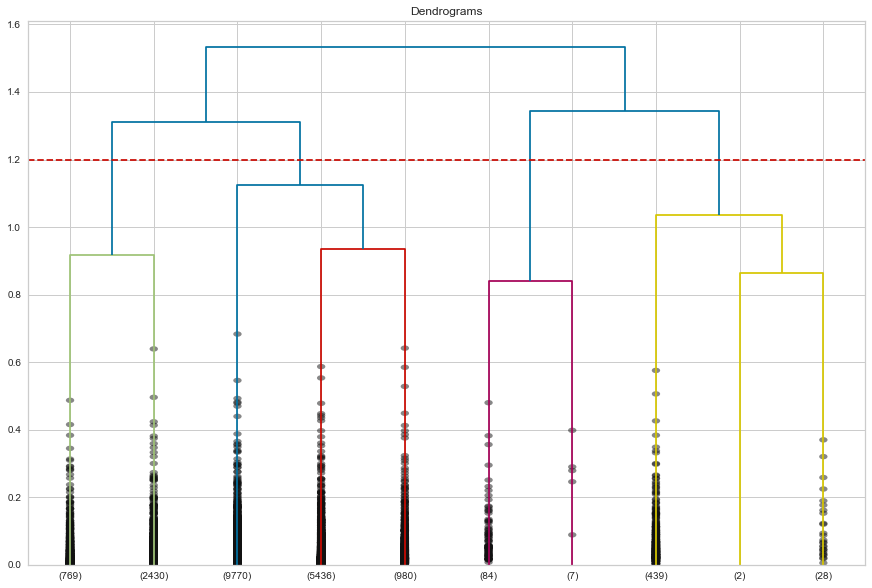

In [224]:
# We determine the optimum number of clusters for hierarchical clustering 
# The best way to determine the number of clusters in hierarchical clustering is to draw a dendrogram

hc_complete = linkage(hc_model_df, 'complete')

plt.figure(figsize=(15, 10))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

In [225]:
# Create our model
# Segment our customer

hc = AgglomerativeClustering(n_clusters=4)

segments = hc.fit_predict(hc_model_df)


In [226]:
final_hc_df = df[["master_id","order_num_total_ever_online",
                  "order_num_total_ever_offline",
                  "customer_value_total_ever_offline",
                  "customer_value_total_ever_online",
                  "recency",
                  "tenure",
                  "order_num_total", 
                  "customer_value_total",
                  "ratio"]]

segments
final_hc_df["hc_segment"] = segments + 1
final_hc_df.head()

# this is the final version of the model made with Hierarchical Clustering

C:\Users\avcil\AppData\Local\Temp\ipykernel_16724\1672601488.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hc_df["hc_segment"] = segments + 1


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,order_num_total,customer_value_total,ratio,hc_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,5.00,939.37,187.87,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,21.00,2013.55,95.88,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,5.00,585.32,117.06,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,2.00,121.97,60.98,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,2.00,209.98,104.99,1


In [227]:
# Size of the clusters

hc_size = final_hc_df.groupby('hc_segment').size().to_frame()
hc_size.columns = ["HC_size"]
hc_size

,HC_size
hc_segment,
1,9585
2,3677
3,4528
4,2155


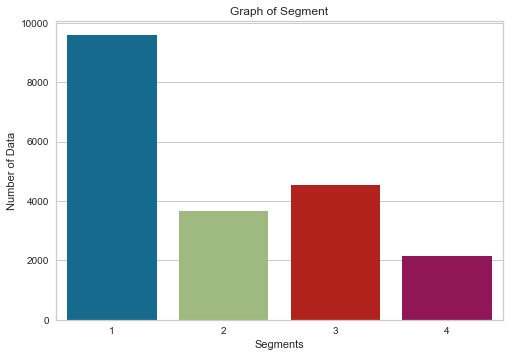

In [228]:
# Cluster membership chart

sns.countplot(x='hc_segment', data=final_hc_df)
plt.title('Graph of Segment')
plt.xlabel('Segments')
plt.ylabel('Number of Data')
plt.show()

In [229]:
# Let's examine each segment statistically

final_hc_df.groupby("hc_segment").agg({ "recency":["min","mean","max"],
                                        "order_num_total":["min","mean","max"],
                                        "customer_value_total": ["min","mean","max"],
                                        "ratio" :["min","mean","max", "count"] })

recency               order_num_total             customer_value_total                  ratio                     
               min   mean    max             min mean    max                  min    mean      max   min   mean     max count
hc_segment                                                                                                                   
1            31.00 179.83 367.00            2.00 3.06  10.00                44.98  450.77  7745.27 22.49 149.37 1106.47  9585
2             8.00  33.96  74.00            2.00 5.04  21.00                69.98  675.53  2941.55 29.32 134.17  597.14  3677
3            12.00 178.03 367.00            4.00 9.07 202.00               301.20 1355.36 45905.10 32.87 153.51 5176.59  4528
4             2.00  12.57  53.00            2.00 5.23  53.00                65.91  947.54 12726.10 32.95 194.64  862.69  2155

In [230]:
# Let's examine each segment statistically

final_hc_df.groupby("hc_segment").agg({ "order_num_total_ever_online":["min","mean","max"],
                                  "order_num_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_online":["min","mean","max"],
                                  "recency":["min","mean","max"],
                                  "tenure":["min","mean","max"],
                                  "order_num_total":["min","mean","max"],
                                  "customer_value_total": ["min","mean","max"],
                                  "ratio" :["min","mean","max", "count"] })

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                 recency               tenure                order_num_total             customer_value_total                  ratio                     
                                   min mean    max                          min mean    max                               min   mean      max                              min   mean      max     min   mean    max    min   mean     max             min mean    max                  min    mean      max   min   mean     max count
hc_segment                                                                                                                                                                                                                                                                                                                             
1                                 1.00 1.57   8.00                         1.00 1.49   8.00                             10.49 198.62  2963.24                            12.99 252.14  7665.28   31.00 179.83 367.00   0.00 542.93 2964.00            2.00 3.06  10.00                44.98  450.77  7745.27 22.49 149.37 1106.47  9585
2                                 1.00 3.06  20.00                         1.00 1.98  18.00                             12.99 235.56  2125.50                            19.99 439.97  2627.69    8.00  33.96  74.00   0.00 693.80 3028.00            2.00 5.04  21.00                69.98  675.53  2941.55 29.32 134.17  597.14  3677
3                                 1.00 6.28 200.00                         1.00 2.78 109.00                             10.00 368.41 18119.14                            19.99 986.95 45220.13   12.00 178.03 367.00   0.00 904.00 3016.00            4.00 9.07 202.00               301.20 1355.36 45905.10 32.87 153.51 5176.59  4528
4                                 1.00 3.39  48.00                         1.00 1.84  24.00                             12.99 290.66  3425.14                            29.74 656.88 12545.37    2.00  12.57  53.00   0.00 673.72 3034.00            2.00 5.23  53.00                65.91  947.54 12726.10 32.95 194.64  862.69  2155

#### Let's set up the same model as n_cluster=10

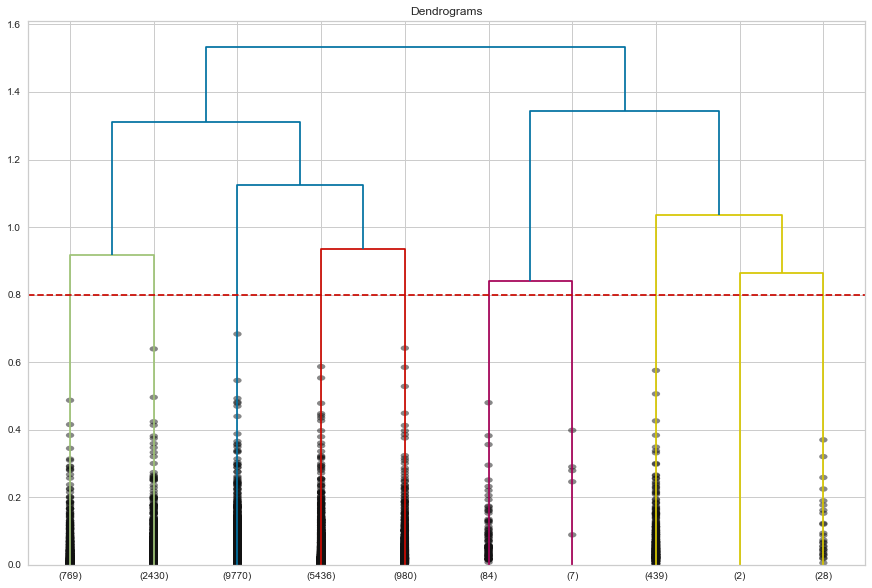

In [231]:
# We determine the optimum number of clusters for hierarchical clustering 
# The best way to determine the number of clusters in hierarchical clustering is to draw a dendrogram

hc_complete = linkage(hc_model_df, 'complete')

plt.figure(figsize=(15, 10))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.8, color='r', linestyle='--')
plt.show()

In [232]:
# Create our model
# Segment our customer

hc_2 = AgglomerativeClustering(n_clusters=10)

hc_2_segments = hc_2.fit_predict(hc_model_df)


In [233]:
hc_2_df = df[["master_id","order_num_total_ever_online",
                  "order_num_total_ever_offline",
                  "customer_value_total_ever_offline",
                  "customer_value_total_ever_online",
                  "recency",
                  "tenure",
                  "order_num_total", 
                  "customer_value_total",
                  "ratio"]]

segments
hc_2_df["hc_2_segment"] = hc_2_segments + 1
hc_2_df.head()

# this is the final version of the model made with Hierarchical Clustering

C:\Users\avcil\AppData\Local\Temp\ipykernel_16724\688210362.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_2_df["hc_2_segment"] = hc_2_segments + 1


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,order_num_total,customer_value_total,ratio,hc_2_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,5.00,939.37,187.87,2
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,21.00,2013.55,95.88,5
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,5.00,585.32,117.06,6
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,2.00,121.97,60.98,7
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,2.00,209.98,104.99,7


In [234]:
# Size of the segments

hc_2_size = hc_2_df.groupby('hc_2_segment').size().to_frame()
hc_2_size.columns = ["HC_size"]
hc_2_size

,HC_size
hc_2_segment,
1,4272
2,3440
3,1463
4,1742
5,439
6,2761
7,1873
8,1935
9,692


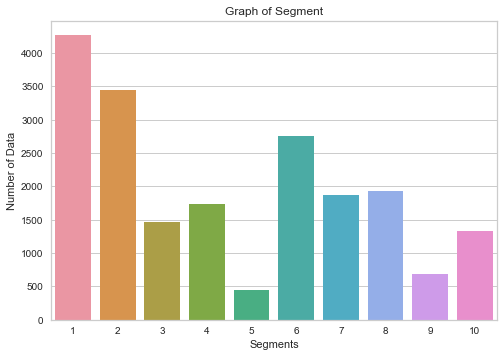

In [235]:
# Cluster membership chart

sns.countplot(x='hc_2_segment', data=hc_2_df)
plt.title('Graph of Segment')
plt.xlabel('Segments')
plt.ylabel('Number of Data')
plt.show()

In [236]:
# Let's examine each segment statistically

hc_2_df.groupby("hc_2_segment").agg({ "recency":["min","mean","max"],
                                        "order_num_total":["min","mean","max"],
                                        "customer_value_total": ["min","mean","max"],
                                        "ratio" :["min","mean","max", "count"] })

recency               order_num_total              customer_value_total                  ratio                     
                 min   mean    max             min  mean    max                  min    mean      max   min   mean     max count
hc_2_segment                                                                                                                    
1             122.00 244.27 367.00            2.00  2.99  10.00               182.56  441.79  1168.36 34.30 155.29  539.99  4272
2              31.00 105.23 360.00            2.00  3.53  10.00               227.77  606.64  7745.27 39.13 180.09 1106.47  3440
3               2.00  14.79  53.00            2.00  3.08   7.00                65.91  609.57  3884.07 32.95 203.06  862.69  1463
4               8.00  31.60  69.00            3.00  7.03  21.00               310.14 1019.01  2941.55 29.32 151.56  597.14  1742
5              12.00 116.53 364.00            4.00 23.78 202.00              1389.85 3711.51 45905.10 45.22 176.21 5176.59   439
6              92.00 232.35 367.00            4.00  6.68  23.00               301.20  999.73 12103.15 32.87 152.37  605.16  2761
7              36.00 169.86 367.00            2.00  2.39   5.00                44.98  184.97   399.93 22.49  79.46  139.99  1873
8               8.00  36.10  74.00            2.00  3.24   9.00                69.98  366.31   769.15 31.63 118.51  264.49  1935
9               2.00   7.86  22.00            3.00  9.79  53.00               314.40 1662.08 12726.10 59.73 176.83  727.09   692
10             40.00  85.41 175.00            5.00  9.17  22.00               511.90 1315.87  3892.92 50.04 148.38  357.06  1328

In [237]:
# Let's examine each segment statistically

hc_2_df.groupby("hc_2_segment").agg({ "order_num_total_ever_online":["min","mean","max"],
                                  "order_num_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_online":["min","mean","max"],
                                  "recency":["min","mean","max"],
                                  "tenure":["min","mean","max"],
                                  "order_num_total":["min","mean","max"],
                                  "customer_value_total": ["min","mean","max"],
                                  "ratio" :["min","mean","max", "count"] })

order_num_total_ever_online              order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                  recency               tenure                 order_num_total              customer_value_total                  ratio                     
                                     min  mean    max                          min mean    max                               min   mean      max                              min    mean      max     min   mean    max    min    mean     max             min  mean    max                  min    mean      max   min   mean     max count
hc_2_segment                                                                                                                                                                                                                                                                                                                                 
1                                   1.00  1.53   8.00                         1.00 1.46   8.00                             12.99 195.23   959.98                            12.99  246.57  1068.18  122.00 244.27 367.00   0.00  506.46 2773.00            2.00  2.99  10.00               182.56  441.79  1168.36 34.30 155.29  539.99  4272
2                                   1.00  1.83   6.00                         1.00 1.70   6.00                             12.99 263.42  2963.24                            14.00  343.22  7665.28   31.00 105.23 360.00   0.00  588.75 2964.00            2.00  3.53  10.00               227.77  606.64  7745.27 39.13 180.09 1106.47  3440
3                                   1.00  1.67   5.00                         1.00 1.41   5.00                             12.99 242.09  1821.90                            29.74  367.48  3444.08    2.00  14.79  53.00   0.00  555.68 2857.00            2.00  3.08   7.00                65.91  609.57  3884.07 32.95 203.06  862.69  1463
4                                   1.00  4.56  20.00                         1.00 2.47  18.00                             12.99 319.45  2125.50                            31.99  699.56  2627.69    8.00  31.60  69.00   2.00  809.59 3028.00            3.00  7.03  21.00               310.14 1019.01  2941.55 29.32 151.56  597.14  1742
5                                   1.00 19.31 200.00                         1.00 4.48 109.00                             12.99 565.53 18119.14                            49.98 3145.98 45220.13   12.00 116.53 364.00  20.00 1397.18 3016.00            4.00 23.78 202.00              1389.85 3711.51 45905.10 45.22 176.21 5176.59   439
6                                   1.00  4.24  22.00                         1.00 2.43  13.00                             10.00 326.57  3215.78                            19.99  673.16 12038.18   92.00 232.35 367.00   0.00  797.73 2865.00            4.00  6.68  23.00               301.20  999.73 12103.15 32.87 152.37  605.16  2761
7                                   1.00  1.18   4.00                         1.00 1.21   4.00                             10.49  87.37   319.97                            14.00   97.60   323.26   36.00 169.86 367.00   0.00  541.94 2828.00            2.00  2.39   5.00                44.98  184.97   399.93 22.49  79.46  139.99  1873
8                                   1.00  1.70   7.00                         1.00 1.54   6.00                             12.99 160.03   522.95                            19.99  206.28   603.89    8.00  36.10  74.00   0.00  589.57 2922.00            2.00  3.24   9.00                69.98  366.31   769.15 31.63 118.51  264.49  1935
9                                   1.00  7.04  48.00                         1.00 2.75  24.00                             19.99 393.35  3425.14                            59.49 1268.73 12545.37    2.00   7.86  22.00   9.00  923.27 3034.00            3.00  9.79  53.00               314.40 1662.08 12726.10 59.73 176.83  727.09   692
10   